# Evaluation Statistics on bioRxiv - PMC links

In [1]:
from pathlib import Path

import pandas as pd
import pickle
import plotnine as p9

from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegressionCV

# Equal Dimension Distance Calculation

In [2]:
potential_links_df = pd.read_csv(
    "output/annotated_links/potential_biorxiv_pmc_links.tsv", sep="\t"
)
potential_links_df.head()

,document,biorxiv_doi,biorxiv_doi_url,pmcid,pmcid_url,distance,distance_bin
0,002097_v1.xml,10.1101/002097,https://doi.org/10.1101/002097,PMC4404056,https://www.ncbi.nlm.nih.gov/pmc/PMC4404056,0.855655,"[0, 25%ile)"
1,568642_v1.xml,10.1101/568642,https://doi.org/10.1101/568642,PMC6797590,https://www.ncbi.nlm.nih.gov/pmc/PMC6797590,0.936722,"[0, 25%ile)"
2,567537_v1.xml,10.1101/567537,https://doi.org/10.1101/567537,PMC6915707,https://www.ncbi.nlm.nih.gov/pmc/PMC6915707,0.971315,"[0, 25%ile)"
3,568477_v1.xml,10.1101/568477,https://doi.org/10.1101/568477,PMC6906737,https://www.ncbi.nlm.nih.gov/pmc/PMC6906737,0.980026,"[0, 25%ile)"
4,490409_v1.xml,10.1101/490409,https://doi.org/10.1101/490409,PMC6544208,https://www.ncbi.nlm.nih.gov/pmc/PMC6544208,0.756873,"[0, 25%ile)"


In [3]:
annotated_df = pd.read_csv(
    "output/annotated_links/final_biorxiv_pmc_links_curation.tsv", sep="\t"
)
annotated_df.head()

,biorxiv_doi_url,pmcid_url,is_same_paper_1,comments_1,is_same_paper_2,comments_2,is_same_paper_3,comments_3
0,https://doi.org/10.1101/148494,https://www.ncbi.nlm.nih.gov/pmc/PMC6292624,True,NaN,True,NaN,NaN,NaN
1,https://doi.org/10.1101/320200,https://www.ncbi.nlm.nih.gov/pmc/PMC6281320,True,NaN,True,NaN,NaN,NaN
2,https://doi.org/10.1101/376665,https://www.ncbi.nlm.nih.gov/pmc/PMC6602326,True,NaN,True,NaN,NaN,NaN
3,https://doi.org/10.1101/721621,https://www.ncbi.nlm.nih.gov/pmc/PMC6957298,True,NaN,True,NaN,NaN,NaN
4,https://doi.org/10.1101/201160,https://www.ncbi.nlm.nih.gov/pmc/PMC6428895,True,NaN,True,NaN,NaN,NaN


In [4]:
kappa_score = cohen_kappa_score(
    annotated_df.is_same_paper_1, annotated_df.is_same_paper_2
)
print(f"The interrator reliability (kappa score) is {kappa_score:%}.")

The interrator reliability (kappa score) is 91.762768%.


In [5]:
final_annotated_df = annotated_df.merge(
    potential_links_df[["biorxiv_doi_url", "pmcid_url", "distance_bin"]]
).assign(
    final_same_paper=lambda x: (
        x[["is_same_paper_1", "is_same_paper_2", "is_same_paper_3"]].mode(axis=1)
    )
)
final_annotated_df.head()

,biorxiv_doi_url,pmcid_url,is_same_paper_1,comments_1,is_same_paper_2,comments_2,is_same_paper_3,comments_3,distance_bin,final_same_paper
0,https://doi.org/10.1101/148494,https://www.ncbi.nlm.nih.gov/pmc/PMC6292624,True,NaN,True,NaN,NaN,NaN,"[50%ile, 75%ile)",True
1,https://doi.org/10.1101/320200,https://www.ncbi.nlm.nih.gov/pmc/PMC6281320,True,NaN,True,NaN,NaN,NaN,"[50%ile, 75%ile)",True
2,https://doi.org/10.1101/376665,https://www.ncbi.nlm.nih.gov/pmc/PMC6602326,True,NaN,True,NaN,NaN,NaN,"[25%ile, 50%ile)",True
3,https://doi.org/10.1101/721621,https://www.ncbi.nlm.nih.gov/pmc/PMC6957298,True,NaN,True,NaN,NaN,NaN,"[25%ile, 50%ile)",True
4,https://doi.org/10.1101/201160,https://www.ncbi.nlm.nih.gov/pmc/PMC6428895,True,NaN,True,NaN,NaN,NaN,"[50%ile, 75%ile)",True


In [6]:
binned_stats_df = (
    final_annotated_df.groupby("distance_bin")
    .final_same_paper.mean()
    .to_frame()
    .rename(index=str, columns={"final_same_paper": "frac_correct"})
    .reset_index()
    .replace(
        {
            "distance_bin": {
                "[0, 25%ile)": "0-25th",
                "[25%ile, 50%ile)": "25th-50th",
                "[50%ile, 75%ile)": "50th-75th",
                "[75%, min(same-journal-no-known-link))": "75th-min(Randomized Journal Pairs)",
            }
        }
    )
)
binned_stats_df

,distance_bin,frac_correct
0,0-25th,1.00
1,25th-50th,0.98
2,50th-75th,0.34
3,75th-min(Randomized Journal Pairs),0.00


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/distance_bin_accuracy.svg
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/distance_bin_accuracy.png


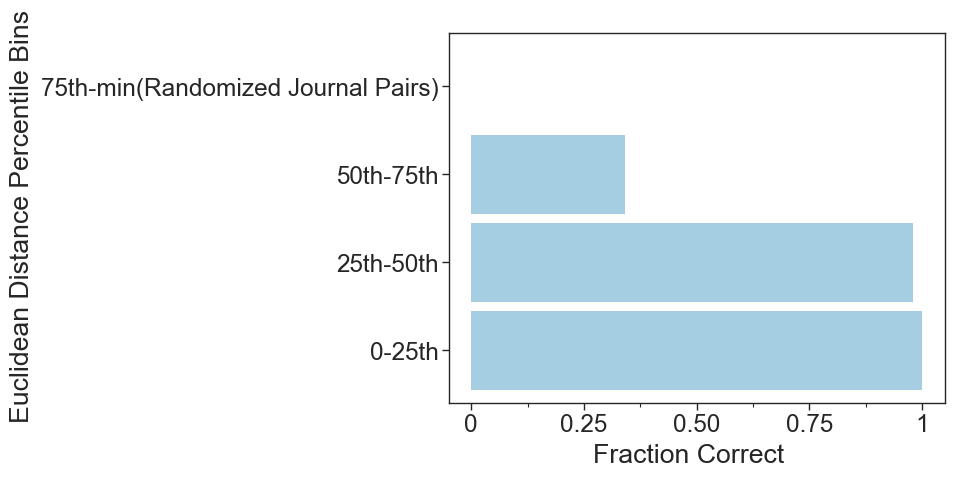

<ggplot: (8739294683333)>


In [7]:
g = (
    p9.ggplot(binned_stats_df, p9.aes(x="distance_bin", y="frac_correct"))
    + p9.geom_col(fill="#a6cee3")
    + p9.coord_flip()
    + p9.labs(y="Fraction Correct", x="Euclidean Distance Percentile Bins")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=2)
)
g.save("output/figures/distance_bin_accuracy.svg")
g.save("output/figures/distance_bin_accuracy.png")
print(g)

# Logsitic Regression Performance

In [8]:
biorxiv_embed_df = pd.read_csv(
    Path("../word_vector_experiment/output/")
    / "word2vec_output/"
    / "biorxiv_all_articles_300.tsv.xz",
    sep="\t",
).set_index("document")
biorxiv_embed_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
440735_v1.xml,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,0.551382,-0.047635,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
775270_v1.xml,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,0.808698,0.066774,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
242404_v1.xml,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,0.385497,0.051444,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
872994_v1.xml,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,0.382142,-0.239683,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
080853_v2.xml,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,0.240977,-0.730841,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


In [9]:
pmc_embed_df = pd.read_csv(
    list(Path("../../pmc/word_vector_experiment/output/").glob("*300.tsv.xz"))[0],
    sep="\t",
).set_index("document")
pmc_embed_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,0.431974,0.244188,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,0.530896,0.018685,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,0.866190,0.422196,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,0.695519,0.374868,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,0.586774,0.474496,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


In [10]:
id_mapper_df = potential_links_df[
    ["document", "biorxiv_doi_url", "pmcid", "pmcid_url"]
].merge(final_annotated_df, on=["biorxiv_doi_url", "pmcid_url"])
id_mapper_df.head()

,document,biorxiv_doi_url,pmcid,pmcid_url,is_same_paper_1,comments_1,is_same_paper_2,comments_2,is_same_paper_3,comments_3,distance_bin,final_same_paper
0,347021_v1.xml,https://doi.org/10.1101/347021,PMC6234284,https://www.ncbi.nlm.nih.gov/pmc/PMC6234284,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True
1,043471_v1.xml,https://doi.org/10.1101/043471,PMC5035412,https://www.ncbi.nlm.nih.gov/pmc/PMC5035412,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True
2,642769_v1.xml,https://doi.org/10.1101/642769,PMC6795488,https://www.ncbi.nlm.nih.gov/pmc/PMC6795488,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True
3,539791_v1.xml,https://doi.org/10.1101/539791,PMC6920352,https://www.ncbi.nlm.nih.gov/pmc/PMC6920352,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True
4,475244_v1.xml,https://doi.org/10.1101/475244,PMC6721383,https://www.ncbi.nlm.nih.gov/pmc/PMC6721383,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True


In [11]:
data_records = []
for idx, row in id_mapper_df[["document", "pmcid"]].iterrows():
    data_records.append(
        dict(
            biorxiv_document=row["document"],
            pmcid=row["pmcid"],
            **(
                biorxiv_embed_df.loc[row["document"]] - pmc_embed_df.loc[row["pmcid"]]
            ).to_dict(),
        )
    )

In [12]:
final_df = pd.DataFrame.from_records(data_records)
final_df.head()

,biorxiv_document,pmcid,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,347021_v1.xml,PMC6234284,0.059594,-0.045069,-0.032220,-0.127837,0.031947,0.012361,0.085642,0.038270,...,0.073360,0.042719,0.032193,-0.040965,-0.024076,0.006792,-0.071338,0.017321,0.030830,-0.025303
1,043471_v1.xml,PMC5035412,0.032431,0.060045,-0.111009,-0.003677,-0.065785,-0.017737,-0.008754,-0.036415,...,0.052937,0.047334,0.033351,-0.012253,0.006341,-0.038205,-0.053062,-0.008881,0.006378,0.047140
2,642769_v1.xml,PMC6795488,0.025575,-0.012193,0.003679,0.057741,-0.092660,-0.024381,0.021392,0.039725,...,0.031004,0.063298,-0.046982,0.035640,-0.013009,-0.040882,-0.033396,0.000161,0.071373,0.147518
3,539791_v1.xml,PMC6920352,-0.049216,-0.072732,-0.077494,-0.104328,-0.040628,0.048381,-0.054285,0.010450,...,0.059819,0.065465,0.009487,0.046904,0.063944,-0.037936,0.005802,0.038042,0.020732,0.087195
4,475244_v1.xml,PMC6721383,-0.047821,0.001098,-0.040569,0.038588,0.028636,-0.010185,0.031438,0.005829,...,-0.038711,0.026967,-0.023120,0.012998,-0.045466,-0.031192,-0.038834,0.100375,-0.000078,-0.031908


In [13]:
model = pickle.load(open("output/optimized_model.pkl", "rb"))

In [14]:
model_predictions = model.predict_proba(
    final_df.drop(["biorxiv_document", "pmcid"], axis=1)
)[:, 1]
model_predictions

array([0.97939377, 0.90353002, 0.84618372, 0.83245738, 0.16138395,
       0.94023014, 0.89056332, 0.84932277, 0.89493313, 0.89829892,
       0.8886741 , 0.95823611, 0.73612667, 0.68092803, 0.77217773,
       0.59393342, 0.3401556 , 0.96952956, 0.27040919, 0.95800511,
       0.91989779, 0.92507071, 0.94718349, 0.9637455 , 0.97832375,
       0.81795645, 0.77612366, 0.85719959, 0.73989746, 0.919552  ,
       0.8448528 , 0.9293825 , 0.76113733, 0.85932762, 0.78511636,
       0.85836446, 0.75523045, 0.91028905, 0.54835296, 0.98820041,
       0.91711201, 0.74125784, 0.86193934, 0.75325546, 0.56313765,
       0.82766071, 0.68394806, 0.48169406, 0.94258833, 0.31334568,
       0.98508942, 0.95171213, 0.98445963, 0.99042333, 0.9713147 ,
       0.94144717, 0.82854281, 0.45169639, 0.88633106, 0.94122516,
       0.99549632, 0.94735515, 0.99213769, 0.98580798, 0.97103715,
       0.89675054, 0.86756123, 0.95681267, 0.99627013, 0.06333999,
       0.11851339, 0.84200632, 0.20728899, 0.98703735, 0.72056

In [15]:
id_mapper_df = id_mapper_df.assign(
    lr_model=list(map(lambda x: True if x > 0.5 else False, model_predictions))
)
id_mapper_df.head()

,document,biorxiv_doi_url,pmcid,pmcid_url,is_same_paper_1,comments_1,is_same_paper_2,comments_2,is_same_paper_3,comments_3,distance_bin,final_same_paper,lr_model
0,347021_v1.xml,https://doi.org/10.1101/347021,PMC6234284,https://www.ncbi.nlm.nih.gov/pmc/PMC6234284,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True,True
1,043471_v1.xml,https://doi.org/10.1101/043471,PMC5035412,https://www.ncbi.nlm.nih.gov/pmc/PMC5035412,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True,True
2,642769_v1.xml,https://doi.org/10.1101/642769,PMC6795488,https://www.ncbi.nlm.nih.gov/pmc/PMC6795488,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True,True
3,539791_v1.xml,https://doi.org/10.1101/539791,PMC6920352,https://www.ncbi.nlm.nih.gov/pmc/PMC6920352,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True,True
4,475244_v1.xml,https://doi.org/10.1101/475244,PMC6721383,https://www.ncbi.nlm.nih.gov/pmc/PMC6721383,True,NaN,True,NaN,NaN,NaN,"[0, 25%ile)",True,False


In [16]:
binned_model_stats_df = (
    id_mapper_df.groupby("distance_bin")
    .agg({"final_same_paper": "mean", "lr_model": "mean"})
    .rename(index=str, columns={"final_same_paper": "frac_correct"})
    .reset_index()
)
binned_model_stats_df

,distance_bin,frac_correct,lr_model
0,"[0, 25%ile)",1.00,0.90
1,"[25%ile, 50%ile)",0.98,0.88
2,"[50%ile, 75%ile)",0.34,0.72
3,"[75%, min(same-journal-no-known-link))",0.00,0.64
